In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy 
import pickle
import matplotlib.pyplot as plt
from glob import glob
import sys
import pandas as pd

In [3]:
sys.path.append('/home/akumar/nse/neural_control')
from utils import apply_df_filters
from neurosim.models.var import form_companion

In [4]:
from sklearn.decomposition import PCA
from dca_research.lqg import LQGComponentsAnalysis as LQGCA

In [5]:
from scipy.stats import ortho_group

In [108]:
# Load the polar decomposition parameterization of A matrices and plot
# (1) the increase of non-normality
# (2) Example plots of the polar decompositions
# (3) Sabes polar decomposition 
# (4) Examples of the pseudospectra

In [7]:
dim = 100
nU = 1
nP = 50
seed = 1
# 50 random U matrices. Then modulate the spread of the diagonals of P for each U

U = []
for i in range(nU):
    U.append(ortho_group.rvs(dim, random_state=seed))


In [8]:
# Just re-generate them here:
Puniform = []
delta = []
for j in range(nP):
    Puniform.append(np.diag(np.linspace(0.8 - j/nP * 0.6, 0.8 + j/nP * 0.6, dim)))
    delta.append(0.8 + j/nP * 0.6 - (0.8 - j/nP * 0.6))

Pclustered = []
for j in range(50):

    # Smaller cluster
    smaller_cluster = np.linspace(0.8 - j/nP * 0.6, 0.8 - j/nP * 0.2, dim//2)
    larger_cluster = np.linspace(0.8 + j/nP * 0.2, 0.8 + j/nP * 0.6, dim//2)
    sigma = np.append(smaller_cluster, larger_cluster)

    # Larger cluster
    Pclustered.append(np.diag(sigma))

# Check to make sure all eigenvalues have real part < 1
A1 = []
A2 = []

lambda_max = np.zeros((nU, nP, 2))
for i in range(len(U)):
    for j in range(len(Puniform)):

        A_ = U[i] @ Puniform[j]
        lambda_max[i, j, 0] = np.max(np.real(np.linalg.eigvals(A_)))     
        A1.append(A_)

        A_ = U[i] @ Pclustered[j]
        lambda_max[i, j, 1] = np.max(np.real(np.linalg.eigvals(A_)))
        A2.append(A_)     

In [111]:
# Load the sabes VAR fits to get the corresponding singular values
# Consolidate
indy_fits = glob('/mnt/Secondary/data/indy_cv_var/indy_cv_var_*.dat')
rl = []
for file_ in indy_fits:
    with open(file_, 'rb') as f:
        args = pickle.load(f)
        coef = pickle.load(f)
    rd = {}
    for key, value in args.items():
        if type(value) == dict:
            for key_, value_ in value.items():
                rd[key_] = value_
        else:
            rd[key] = value
    
    rd['coef'] = coef
    rl.append(rd)
indy_df = pd.DataFrame(rl)

In [112]:
data_files = np.unique(indy_df['data_file'].values)

In [113]:
df_ = apply_df_filters(indy_df, data_file=data_files[0], fold_idx = 2, order=3)
A_M1 = form_companion(df_.iloc[0]['coef'])

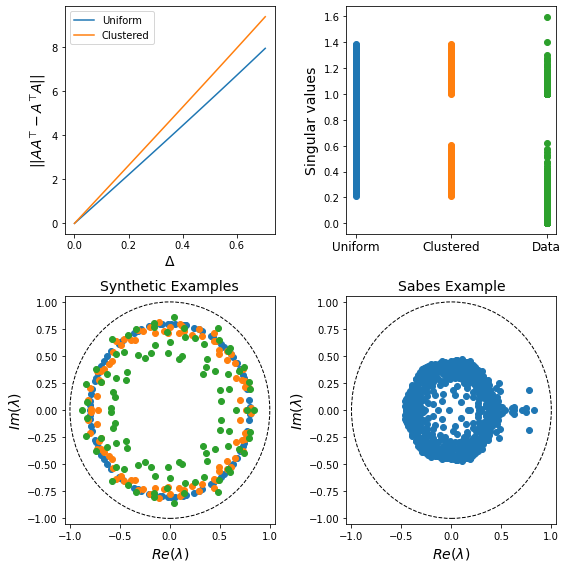

In [131]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))

nn = np.zeros((len(Puniform), 2))
for i in range(len(Puniform)):
    nn[i, 0] = np.linalg.norm(A1[i] @ A1[i].T - A1[i].T @ A1[i])
    nn[i, 1] = np.linalg.norm(A2[i] @ A2[i].T - A2[i].T @ A2[i])
ax[0, 0].plot(np.array(delta) * 0.6, nn[:, 0])
ax[0, 0].plot(np.array(delta) * 0.6, nn[:, 1])
ax[0, 0].legend(['Uniform', 'Clustered'])
ax[0, 0].set_ylabel(r'$||AA^\top - A^\top A||$', fontsize=14)
ax[0, 0].set_xlabel(r'$\Delta$', fontsize=14)

_, s1, _ = np.linalg.svd(A1[-1])
_, s2, _ = np.linalg.svd(A2[-1])
_, s3, _ = np.linalg.svd(A_M1)

ax[0, 1].scatter(np.zeros(s1.size), s1)
ax[0, 1].scatter(np.ones(s1.size), s2)
ax[0, 1].scatter(2 * np.ones(s3.size), s3)

ax[0, 1].set_xticks([0, 1, 2])
ax[0, 1].set_xticklabels(['Uniform', 'Clustered', 'Data'], fontsize=12)
ax[0, 1].set_ylabel('Singular values', fontsize=14)

circle1 = plt.Circle((0, 0), 1, color='k', fill=False, linestyle='--')
ax[1, 0].add_patch(circle1)

circle1 = plt.Circle((0, 0), 1, color='k', fill=False, linestyle='--')
ax[1, 1].add_patch(circle1)

# Plot the spectra of a few examples from Pclustered
eig1 = np.linalg.eigvals(A2[0])
eig2 = np.linalg.eigvals(A2[25])
eig3 = np.linalg.eigvals(A2[-1])
ax[1, 0].scatter(np.real(eig1), np.imag(eig1))
ax[1, 0].scatter(np.real(eig2), np.imag(eig2))
ax[1, 0].scatter(np.real(eig3), np.imag(eig3))
ax[1, 0].set_xlim([-1.05, 1.05])
ax[1, 0].set_ylim([-1.05, 1.05])
ax[1, 0].set_ylabel(r'$Im(\lambda)$', fontsize=14)
ax[1, 0].set_xlabel(r'$Re(\lambda)$', fontsize=14)
ax[1, 0].set_title('Synthetic Examples', fontsize=14)

eig = np.linalg.eigvals(A_M1)
ax[1, 1].scatter(np.real(eig), np.imag(eig))
ax[1, 1].set_xlim([-1.05, 1.05])
ax[1, 1].set_ylim([-1.05, 1.05])
ax[1, 1].set_ylabel(r'$Im(\lambda)$', fontsize=14)
ax[1, 1].set_xlabel(r'$Re(\lambda)$', fontsize=14)
ax[1, 1].set_title('Sabes Example', fontsize=14)

fig.tight_layout()
fig.savefig('/home/akumar/nse/neural_control/figs/synth/polar_example.pdf', bbox_inches='tight', pad_inches=0)

In [124]:
U = ortho_group.rvs(2)
P = np.diag([0.99, 0.99])
A = U @ P

In [125]:
P2 = np.diag([0.75, 1.25])
A2 = U @ P2
P3 = np.diag([0.5, 1.5])
A3 = U @ P3

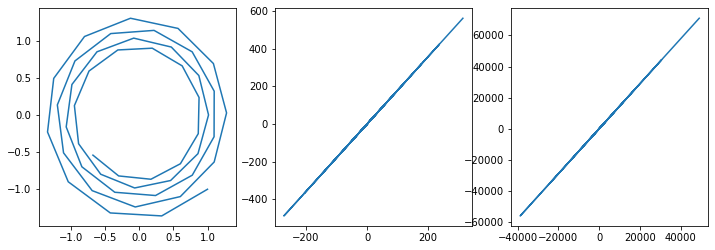

In [126]:
# Plot what happens in a 2D case when the P becomes heterogenous
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

x1 = np.array([np.linalg.matrix_power(A, k) @ np.array([1, -1]) for k in range(50)])
x2 = np.array([np.linalg.matrix_power(A2, k) @ np.array([1, -1]) for k in range(50)])
x3 = np.array([np.linalg.matrix_power(A3, k) @ np.array([1, -1]) for k in range(50)])

ax[0].plot(x[:, 0], x[:, 1])
ax[1].plot(x2[:, 0], x2[:, 1])
ax[2].plot(x3[:, 0], x3[:, 1])

fig.savefig('/home/akumar/nse/neural_control/figs/synth/polar_2D_example.pdf', bbox_inches='tight', pad_inches=0)

In [1]:
# Mock plot of the subspace angle diversion with non-normality

In [6]:
import sys
sys.path.append('/home/akumar/nse/neural_control')

In [7]:
from utils import calc_loadings

In [8]:
from neurosim.models.ssr import StateSpaceRealization as SSR
from tqdm import tqdm
import torch
import pdb

In [12]:
directedness = np.linspace(0, 1, 20)[::-1]
reps = 100

spearmanr = np.zeros((directedness.size, reps, 2))
phi = np.zeros((directedness.size, reps, 2))

size = 100
d=6
for ii, d_ in tqdm(enumerate(directedness)):
    for jj in range(reps):
        A = np.zeros((size, size))
        for i in range(A.shape[0]):
            for j in range(i + 1):
                a = 1/(2 * np.sqrt(size)) * np.random.normal(0, 1)
                if i != j:
                    p = scipy.stats.bernoulli.rvs(0.5)
                    if p:
                        A[i, j] = a
                        A[j, i] = d_ * A[i, j]
                    else:
                        A[j, i] = a
                        A[i, j] = d_ * A[j, i]
                        
                else:
                    A[i, i] = a
                
            
#        while max(np.real(np.linalg.eigvals(A))) > 0:
        while max(np.abs(np.linalg.eigvals(A))) > 0.99:
            # print('Unstable, trying again')
            A = np.zeros((size, size))
            for i in range(A.shape[0]):
                for j in range(i + 1):
                    a = 1/(2 * np.sqrt(size)) * np.random.normal(0, 1)
                    if i != j:
                        p = scipy.stats.bernoulli.rvs(0.5)
                        if p:
                            A[i, j] = a
                            A[j, i] = d_ * A[i, j]
                        else:
                            A[j, i] = a
                            A[i, j] = d_ * A[j, i]

                    else:
                        A[i, i] = a

        ssr = SSR(A=A, B = np.eye(A.shape[0]), C=np.eye(A.shape[0]))

        cross_covs = ssr.autocorrelation(10)
        cross_covs_rev = [np.linalg.inv(cross_covs[0]) @ c.T @ np.linalg.inv(cross_covs[0]) for c in cross_covs]

        cross_covs = torch.tensor(cross_covs)
        cross_covs_rev = torch.tensor(cross_covs_rev)
        
        e, Upca = np.linalg.eig(cross_covs[0])
        eigorder = np.argsort(e)[::-1]
        Upca = Upca[:, eigorder][:, 0:d]

        lqgmodel = LQGCA(d=2, T=1)
        lqgmodel.cross_covs = cross_covs
        lqgmodel.cross_covs_rev = cross_covs_rev

        Ulqg, _ = lqgmodel._fit_projection()

        phi[ii, jj, 0] = np.mean(scipy.linalg.subspace_angles(Upca, Ulqg))
        spearmanr[ii, jj, 0] = scipy.stats.spearmanr(calc_loadings(Upca), calc_loadings(Ulqg))[0]

        cross_covs = ssr.autocorrelation(10)
        cross_covs_rev = [c.T for c in cross_covs]
        cross_covs_rev = torch.tensor(cross_covs_rev)
        cross_covs = torch.tensor(cross_covs)
        lqgmodel = LQGCA(d=2, T=1)
        lqgmodel.cross_covs = cross_covs
        lqgmodel.cross_covs_rev = cross_covs_rev

        Ulqg, _ = lqgmodel._fit_projection()
        phi[ii, jj, 1] = np.mean(scipy.linalg.subspace_angles(Upca, Ulqg))
        spearmanr[ii, jj, 1] = scipy.stats.spearmanr(calc_loadings(Upca), calc_loadings(Ulqg))[0]


20it [07:46, 23.34s/it]


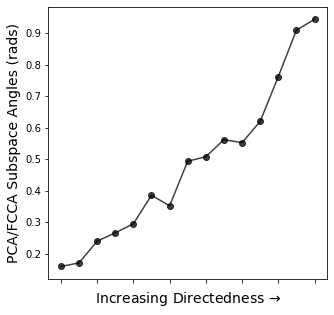

In [25]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(np.mean(phi[5:, 0], axis=1), color='k', alpha=0.75, marker='o')
#plt.plot(np.mean(phi[..., 1], axis=1))
ax.set_xlabel('Increasing Directedness ' + r'$\to$', fontsize=14)
ax.set_ylabel('PCA/FCCA Subspace Angles (rads)', fontsize=14)
ax.set_xticklabels([])
fig.savefig('synth_example.pdf', bbox_inches='tight', pad_inches=0)
#plt.legend(['FCCA new', 'FCCA old'], fontsize=12)

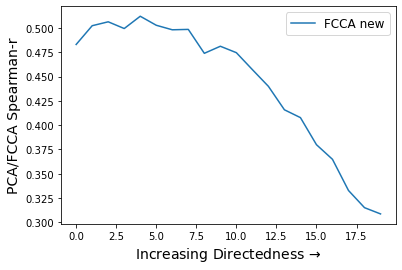

In [14]:
plt.plot(np.mean(spearmanr[..., 0], axis=1))
# plt.plot(np.mean(spearmanr[..., 1], axis=1))
plt.xlabel('Increasing Directedness ' + r'$\to$', fontsize=14)
plt.ylabel('PCA/FCCA Spearman-r', fontsize=14)
plt.legend(['FCCA new', 'FCCA old'], fontsize=12)

In [19]:
subspace_angles = []
subspace_angles2 = []
nn = []
d = 6
for i in tqdm(range(len(Puniform))):

    A = U[0] @ Puniform[i]

    ssr = SSR(A=A, B = np.eye(A.shape[0]), C=np.eye(A.shape[0]))

    cross_covs = ssr.autocorrelation(10)
    cross_covs_rev = [np.linalg.inv(cross_covs[0]) @ c.T @ np.linalg.inv(cross_covs[0]) for c in cross_covs]

    cross_covs = torch.tensor(cross_covs)
    cross_covs_rev = torch.tensor(cross_covs_rev)
    
    e, Upca = np.linalg.eig(cross_covs[0])
    eigorder = np.argsort(e)[::-1]
    pdb.set_trace()
    Upca = Upca[:, eigorder][:, 0:d]

    lqgmodel = LQGCA(d=6, T=1)
    lqgmodel.cross_covs = cross_covs
    lqgmodel.cross_covs_rev = cross_covs_rev

    Ulqg, _ = lqgmodel._fit_projection()

    nn.append(np.linalg.norm(A @ A.T - A.T @ A))
    subspace_angles.append(np.mean(scipy.linalg.subspace_angles(Upca, Ulqg)))


    cross_covs = ssr.autocorrelation(10)
    cross_covs_rev = [c.T for c in cross_covs]
    cross_covs_rev = torch.tensor(cross_covs_rev)
    cross_covs = torch.tensor(cross_covs)
    lqgmodel = LQGCA(d=6, T=3)
    lqgmodel.cross_covs = cross_covs
    lqgmodel.cross_covs_rev = cross_covs_rev

    Ulqg, _ = lqgmodel._fit_projection()
    subspace_angles2.append(np.mean(scipy.linalg.subspace_angles(Upca, Ulqg)))

  0%|          | 0/50 [00:00<?, ?it/s]

> /tmp/ipykernel_6261/2478906062.py(20)<module>()
     18     eigorder = np.argsort(e)[::-1]
     19     pdb.set_trace()
---> 20     Upca = Upca[:, eigorder][:, 0:d]
     21 
     22     lqgmodel = LQGCA(d=6, T=1)

array([2.77777778+0.0000000e+00j, 2.77777778+0.0000000e+00j,
       2.77777778+0.0000000e+00j, 2.77777778+0.0000000e+00j,
       2.77777778+0.0000000e+00j, 2.77777778+0.0000000e+00j,
       2.77777778+0.0000000e+00j, 2.77777778+0.0000000e+00j,
       2.77777778+0.0000000e+00j, 2.77777778+0.0000000e+00j,
       2.77777778+0.0000000e+00j, 2.77777778+0.0000000e+00j,
       2.77777778+0.0000000e+00j, 2.77777778+0.0000000e+00j,
       2.77777778+0.0000000e+00j, 2.77777778+0.0000000e+00j,
       2.77777778+0.0000000e+00j, 2.77777778+0.0000000e+00j,
       2.77777778+0.0000000e+00j, 2.77777778+0.0000000e+00j,
       2.77777778+0.0000000e+00j, 2.77777778+0.0000000e+00j,
       2.77777778+0.0000000e+00j, 2.77777778+0.0000000e+00j,
       2.77777778+0.0000000e+00j, 2.77777778+0.000000

  0%|          | 0/50 [00:45<?, ?it/s]


BdbQuit: 

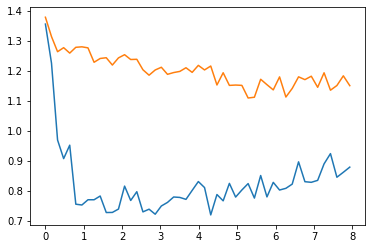

In [16]:
plt.plot(nn, subspace_angles)
plt.plot(nn, subspace_angles2)

In [ ]:
# Cleanup and plot variance